In [1]:
import os
import threading
import time


import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from tqdm import tqdm
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.optim import Adam

from kfp_updated import construct_B, diffusion_coeff, construct_R, construct_P, gauss_seidel, solve_pde, logsumexp, construct_A
from network import ScoreNet
#from net_network import UNet

import PIL

np.random.seed(2)
torch.manual_seed(2)


# create a.so if doesnt exists
if not os.path.isfile("../sparse_gaussian_elimination/a.so"):
    os.system("make -C ../sparse_gaussian_elimination a.so")


mnist = MNIST('.', download=True)

channels = 1
n_data = 1

%load_ext line_profiler


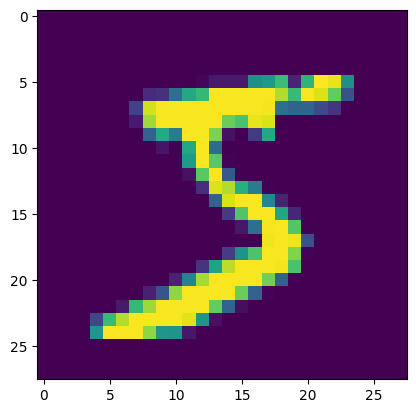

In [2]:
plt.imshow(mnist.data[0]);

In [3]:
## construct the grid and Initial values
batch_size = 32
N = 10
H = 28
W = 28
epoch = 5
eps = 1e-6

channels = 3

t = np.linspace(eps, 1, N)
dt = 1/N

sigma = 25

# create model
model_score = ScoreNet(H=H, W=W, in_channels=channels)
loss_fn = torch.nn.MSELoss()
optimizer = Adam(model_score.parameters(), lr=1e-3)
mm_scaler = MinMaxScaler()
model_score.train();

#scores = np.random.rand(N, channels, H, W).astype(np.float64)
scores = np.zeros((N,channels, H, W), dtype=np.float32)

params = {"bandwidth": np.logspace(-1, 1, 20)}
kdes = np.full((n_data, channels), None)

P = construct_P(int(W), int(H/2))
P_block = sp.linalg.block_diag(*([P] * (N-1)))
sparse_P_block = sp.sparse.block_diag(([P] * (N-1)))

R = construct_R(P)
R_block = sp.linalg.block_diag(*([R] * (N-1)))
sparse_R_block = sp.sparse.block_diag(([R] * (N-1)))


In [4]:
def diffuse(data, x, m , del_m, m_c, channel, train_xc_data, train_x_data, train_y_data, random_t, time_, sigma_, data_idx):
    data = data[channel]
    dx = data.detach().numpy().max()/H
    dy = data.detach().numpy().max()/W
    x[channel][0] = torch.tensor(mm_scaler.fit_transform(data.ravel()[:, None]).astype(np.float32)).reshape((1, 1, H, W))
    
    if not kdes[data_idx, channel]:
      grid = GridSearchCV(KernelDensity(), params)
      kdes[data_idx, channel] = grid.fit(data.ravel()[:, None]) # 0.7 sec
    
    m[channel][0] = kdes[data_idx, channel].score_samples(data.ravel()[:, None])
    del_m[channel][0] = np.diff(m[channel][0].ravel(), axis=0, prepend=m[channel][0,0])
    
    # we normalize for sigma to ensure the dynamics doesn't blow up
    As = []
    for i, t_ in enumerate(random_t, 1):
      A = construct_A(dx, dy, t_ - time_[i-1], np.sqrt(2) * sigma_[i], scores[i][channel].ravel(), H, W)
      As.append(A)

    A_block = sp.linalg.block_diag(*As)
    for i, t_ in enumerate(random_t, 1):
      if i == 1:
        continue
      A_block[(i-1)*H*W:i*H*W, (i-2)*H*W:(i-1)*H*W] = -np.eye((H*W))/(t_ - time_[i-1])
    
    
    B = construct_B(dx, dy, time_[1] - time_[0], m[channel][0].ravel(), np.zeros((H*W)), sigma_[1], scores[i][channel].ravel())
    B_block = np.zeros(A_block.shape[0])
    B_block[:H*W] = B
    
    # update m (pre-smoothing)
    
    m[channel][1:] = gauss_seidel(A_block, B_block, scores[1:, channel].flatten(), A_block.shape[0]).reshape(((N-1), H*W)) # 0.4
    
    
    ##### 0.5
    # we want to perform the coarse grid
    # compute residual r = b - Am[1:]
    r = B_block - A_block@(m[channel][1:]).flatten()
    # coursening step 1: r_c = R_c@r
    r_c = R_block@r
    # coursening A_c = R_c@A@P_c (Petrov-Galerkin Coursening)

    sparse_A_block = sparse.csr_matrix(A_block)
    
    A_c = (sparse_R_block@sparse_A_block@sparse_P_block) # 0.5
    
    # compute course err: err_c = solve_pde(A_c,r_c)
    err_c = solve_pde(A_c, r_c, mode='sp_sparse')
    
    # interpolate to fine grid: err = P_c@err_c
    #print(P_block.shape)
    #print(err_c)
    err = P_block@err_c
    # we apply fine grid-correction
    m[channel][1:] = (m[channel][1:].flatten() + err).reshape((N-1, H*W))
    # post smoothing
    m[channel][1:] = gauss_seidel(A_block, B_block, m[channel][1:].flatten(), A_block.shape[0]).reshape(((N-1), H*W))

    # we want to coarsen the score function to train on coarse data
    m_c[channel][1:] = (R_block@m[channel][1:].flatten()).reshape((-1, int(H*W/4)))

    # constructing the training data and labels
    for i, t_ in enumerate(random_t, 1):
      del_m[channel][i] = np.diff(m[channel][i].ravel(), axis=0, prepend=m[channel][i, 0])

    x = torch.tensor(mm_scaler.fit_transform(np.exp((-m[channel].ravel() - logsumexp(-m[channel].ravel())))[:, None])).reshape((N, 1, H, W))
    perturbed_x = x + torch.randn_like(x) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None, None]
    train_x_data[:, channel] = perturbed_x[:, 0]
    train_y_data[:, channel] = torch.tensor(del_m[channel].astype(np.float32)).reshape((N, H, W))

    # generate coarse dataset
    x_c = torch.tensor(mm_scaler.fit_transform(np.exp((-m_c[channel].ravel() - logsumexp(-m_c[channel].ravel())))[:, None])).reshape((N, int(H/2), int(W/2)))
    perturbed_xc = x_c + torch.randn_like(x_c) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None]
    train_xc_data[:, channel] = perturbed_xc

In [9]:

x = torch.zeros((channels, N, H, W))
m = np.zeros((channels, N, H*W), dtype=np.float32)
del_m = np.zeros_like(m, dtype=np.float32)
m_c = np.zeros((channels, N, int((H*W/4))), dtype=np.float32)
# we want to sample from random time steps to construct training samples
random_t = np.linspace([dt + eps] * n_data, [1] * n_data, N-1, axis=1).astype(np.float64)
random_t += np.random.uniform(-dt/2, dt/2, random_t.shape)
random_t[:, -1] = 1
time_ = np.sort(np.insert(random_t, 0, eps, axis=1), axis=1).astype(np.float32)
sigma_ = diffusion_coeff(torch.tensor(time_), sigma).detach().cpu().numpy()

data = mnist.data[0].reshape(1, 28, 28)
train_xc_data = torch.zeros((N, channels, int(H/2), int(W/2)))
train_x_data = torch.zeros((N, channels, H, W))
train_y_data = torch.zeros_like(train_x_data)

#%lprun -u 0.1 -f construct_A_test construct_A_test(0.01, 0.01, random_t[0] - time_[0][:N-1],  np.zeros((N-1, H, W)), sigma_[0][1:], scores[1:, 0], H, W)
%lprun -u 0.1 -f diffuse diffuse(data, x, m, del_m, m_c, 0, train_xc_data, train_x_data, train_y_data, random_t[0], time_[0], sigma_[0], 0)

Timer unit: 0.1 s

Total time: 1.38967 s
File: /tmp/ipykernel_2472575/3416826710.py
Function: diffuse at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def diffuse(data, x, m , del_m, m_c, channel, train_xc_data, train_x_data, train_y_data, random_t, time_, sigma_, data_idx):
     2         1          0.0      0.0      0.0      data = data[channel]
     3         1          0.0      0.0      0.0      dx = data.detach().numpy().max()/H
     4         1          0.0      0.0      0.0      dy = data.detach().numpy().max()/W
     5         1          0.0      0.0      0.1      x[channel][0] = torch.tensor(mm_scaler.fit_transform(data.ravel()[:, None]).astype(np.float32)).reshape((1, 1, H, W))
     6                                               
     7         1          0.0      0.0      0.0      if not kdes[data_idx, channel]:
     8                                                 grid = GridSearchCV(KernelDensity()

In [6]:
a = np.array([[1, 2, 3], [3, 4, 5]])
b = np.array([1, 2, 3])
(a + b).shape

(2, 3)

In [7]:
a.shape

(2, 3)

In [8]:
a.shape

(2, 3)